In [1]:
%aiida demo

Loaded AiiDA DB environment - profile name: demo.

In [2]:
from pymatgen import Structure

In [3]:
from aiida_user_addons.common.inputset.vaspsets import VASPInputSet
from aiida_user_addons.vworkflows.relax  import VaspRelaxWorkChain, RelaxOptions
from aiida_user_addons.vworkflows.phonopy import VaspAutoPhononWorkChain

In [4]:
from aiida.orm import StructureData

In [6]:
nacl = load_node("7fac61fb-91df-49f3-b639-b3d182cf8b46")

In [7]:
builder = VaspAutoPhononWorkChain.get_builder()

In [45]:
!verdi plugin list aiida.workflows vaspu.phonopy

Description:

	VaspAutoPhononWorkChain
	
	A workchain to perform automated relaxation followed by finite displacement
	single point calculations and finally use phonopy to obtain the band structure
	and density of states.

Inputs:
           phonon_settings:  required  Dict           Settings for the underlying phonopy calculations
               singlepoint:  required                 Additional inputs for the singlepoint calculations.
                 structure:  required  StructureData  Structure of which the phonons should calculated
                  metadata:  optional                 
                       nac:  optional                 Inputs for the DFPT NAC calculation.
                   options:  optional  Dict           Options for the remote phonopy calculation
               phonon_code:  optional  Code           Code for the phonopy for remote calculations
                     relax:  optional                 Inputs for the relaxation to be performed.
            remote

## Prepare the inputs

In [19]:
inputset = VASPInputSet("UCLRelaxSet", nacl, overrides={'encut': 600, 'addgrid': True, 'ediff': 1e-7, 'lorbit': None, 'lvhar': None, "ncore":8, 'ispin': 1,
                                                        'ldauu_mapping': {'Ti': ['d', 0.0]}, 'magmom': None})

builder.structure = nacl
builder.relax.vasp.parameters = Dict(dict={'vasp': inputset.get_input_dict()})
builder.relax.vasp.potential_family = Str('PBE.54')
builder.relax.vasp.potential_mapping = Dict(dict=inputset.get_pp_mapping())
builder.relax.vasp.options = Dict(dict={
    'resources': {'num_machines': 1, 'tot_num_mpiprocs': 16}
})
builder.relax.vasp.kpoints_spacing = Float(0.05)
ropts = RelaxOptions()
ropts.force_cutoff = 1e-3
builder.relax.relax_settings = ropts.to_aiida_dict()
builder.relax.vasp.code = Code.get_from_string("vasp-5.4.4-std@melon-n")

In [20]:
sp = builder.singlepoint

In [21]:
spinputset = VASPInputSet("UCLRelaxSet", StructureData(ase=nacl.get_ase().repeat((2,2,2))), 
                          overrides={'encut': 600, 'addgrid': True, 'ediff': 1e-7, 'lorbit': None, 'lvhar': None,
                                     'ncore': 8, 'ispin':1, 
                                     'ldauu_mapping': {'Ti': ['d', 0.0]}, 'magmom': None})

sp.parameters = Dict(dict={'vasp': spinputset.get_input_dict()})
sp.potential_family = Str('PBE.54')
sp.potential_mapping = Dict(dict=spinputset.get_pp_mapping())
sp.options = Dict(dict={
    'resources': {'num_machines': 1, 'tot_num_mpiprocs': 16}})
sp.kpoints_spacing = Float(0.05)

sp.code = Code.get_from_string("vasp-5.4.4-std@melon-n")


In [22]:
nac = builder.nac

In [27]:
nacinputset = VASPInputSet("UCLRelaxSet", nacl, 
                          overrides={'encut': 600, 'addgrid': True, 'ediff': 1e-7, 'lorbit': None, 'lvhar': None,
                                     'ncore': None, 'ispin':1, 'lepsilon': True, 
                                     'ldauu_mapping': {'Ti': ['d', 0.0]}, 'magmom': None})
nac.parameters = Dict(dict={'vasp': nacinputset.get_input_dict()})
nac.potential_family = Str('PBE.54')
nac.potential_mapping = Dict(dict=nacinputset.get_pp_mapping())
nac.options = Dict(dict={
    'resources': {'num_machines': 1, 'tot_num_mpiprocs': 16}})
nac.kpoints_spacing = Float(0.05)
nac.code = Code.get_from_string("vasp-5.4.4-std@melon-n")


In [28]:
builder.phonon_settings = Dict(dict={
    'supercell_matrix': [2, 2, 2],
    'mesh': 10,
})

In [29]:
builder.metadata.label = 'NaCl Phonon'

In [30]:
from aiida.engine import submit

In [31]:
submit(builder)

<WorkChainNode: uuid: eb1c4eee-86ee-4321-a0e0-0f8d6e7446ea (pk: 34176) (aiida_user_addons.vworkflows.phonopy.VaspAutoPhononWorkChain)>

## Analysis

In [5]:
work = load_node("eb1c4eee")

Quick visualisation for the band structure

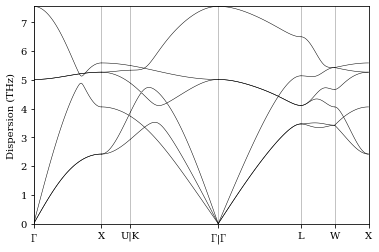

In [6]:
work.outputs.band_structure.show_mpl()

Plot the total density of states

In [10]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Total DOS (1/THz)')

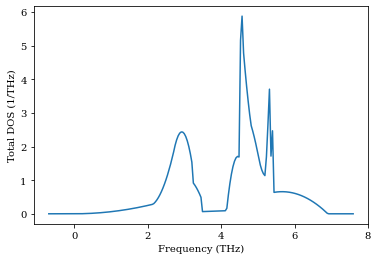

In [35]:
dos = work.outputs.dos
xlabel, x, xunit = dos.get_x()
ylabel, y, yunit = dos.get_y()[0]
plt.plot(x, y)
plt.xlabel(xlabel + f' ({xunit})')
plt.ylabel(ylabel + f' ({yunit})')

The *force constants* and *force sets* arrays can also be accessed - one can use them to redo phonon calculations with different setting using the phonopy Python API  

In [22]:
work.outputs.force_constants.get_array('force_constants').shape

(64, 64, 3, 3)

In [37]:
work.outputs.force_sets.get_array('force_sets').shape

(2, 64, 3)

## Provenance visualisation of the workflow

In [23]:
from aiida.tools.visualization import Graph

g = Graph()
g.recurse_descendants(work)
g.recurse_ancestors(work, depth=1)

In [46]:
g.graphviz.render('phonon', format='png')

'phonon.png'

![Phonon Provenance](phonon.png)